In [1]:
%matplotlib inline
import os
os.chdir("../")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm_notebook as tqdm
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from malenov.model import MalenovNet
from malenov.dataset import MalenovDataset
from malenov.utils import get_train_val_set

/home/lm715/anaconda2/envs/asi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lm715/anaconda2/envs/asi/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [90]:
seed = 42
cube_size = 32
# CUDA setting
if not torch.cuda.is_available():
    raise ValueError("Doesn't make much sense without a GPU. Expect long training times.")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda')
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.backends.cudnn.benchmark = False #To combat randomness

## Stratified Shuffle Split 0.8 Train/ 0.2 Val Results

In [91]:
seismic, X_train, y_train, X_val, y_val = get_train_val_set(use_stratified_kfold=True)

train_dset = MalenovDataset(seismic, X_train, y_train, cube_size)
val_dset = MalenovDataset(seismic, X_val, y_val, cube_size)

train_loader = DataLoader(train_dset, shuffle=True, batch_size=32, num_workers=2)
val_loader = DataLoader(val_dset, shuffle=False, batch_size=32, num_workers=2)

Labels in TRAIN: 111124 Labels in TEST: 13891


In [92]:
model = MalenovNet()
model.load_state_dict(torch.load("./results/malenov/180913_2001/model_epoch_9.pth.tar")['model'])
model.cuda()
model.eval()

MalenovNet(
  (conv1): Conv3d(1, 50, kernel_size=(5, 5, 5), stride=(4, 4, 4), padding=(2, 2, 2))
  (bn1): BatchNorm3d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(50, 50, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn2): BatchNorm3d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout3d(p=0.2)
  (conv3): Conv3d(50, 50, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn3): BatchNorm3d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout3d(p=0.2)
  (conv4): Conv3d(50, 50, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn4): BatchNorm3d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop4): Dropout3d(p=0.2)
  (conv5): Conv3d(50, 50, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (linear1): Linear(in_features=400, out_features=50, bias=True)
  (bn_ln1): BatchNorm1d(50, eps=1e-05, momentum=0.1, a

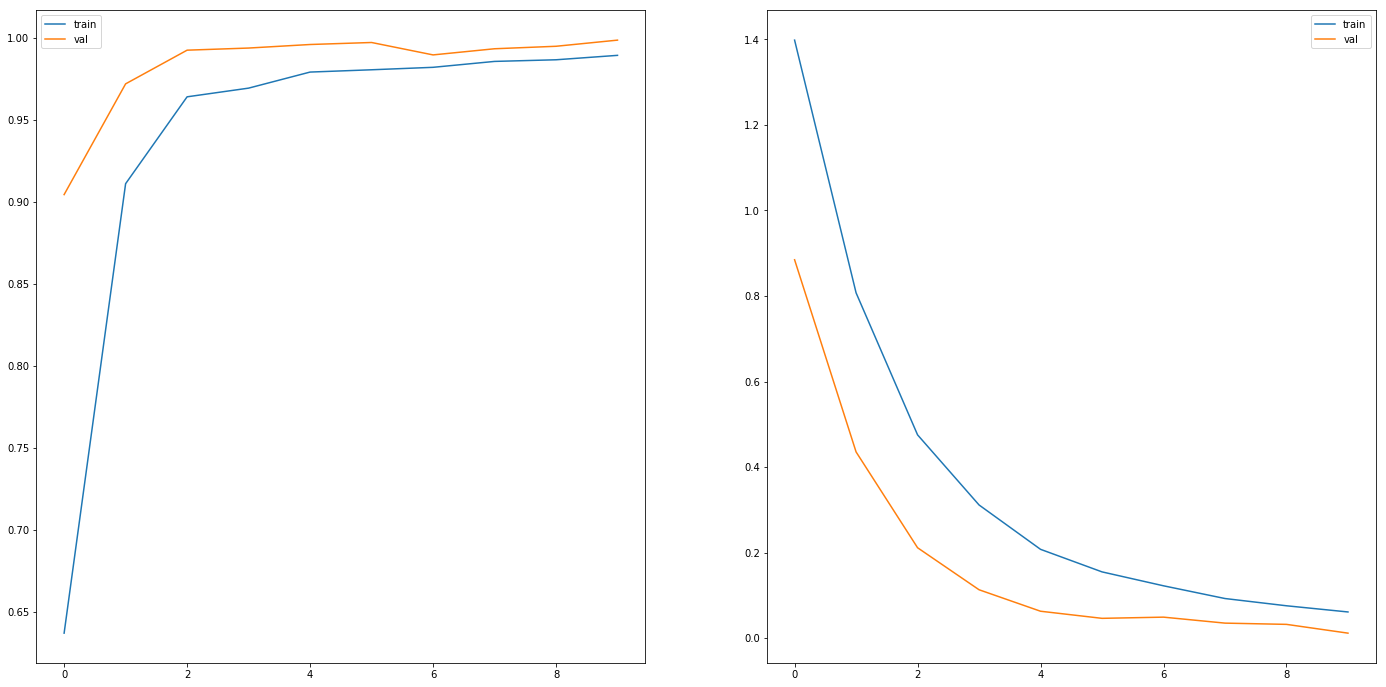

In [94]:
split_train_acc = np.loadtxt("./results/malenov/180913_2001/csv/run_180913_2001_train-tag-accuracy.csv", skiprows=1, delimiter=",")
split_val_acc = np.loadtxt("./results/malenov/180913_2001/csv/run_180913_2001_val-tag-accuracy.csv", skiprows=1, delimiter=",")
split_train_loss = np.loadtxt("./results/malenov/180913_2001/csv/run_180913_2001_train-tag-loss.csv", skiprows=1, delimiter=",")
split_val_loss = np.loadtxt("./results/malenov/180913_2001/csv/run_180913_2001_val-tag-loss.csv", skiprows=1, delimiter=",")

fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].plot(split_train_acc[:, 2], label="train")
ax[0].plot(split_val_acc[:, 2], label="val")

ax[1].plot(split_train_loss[:, 2], label="train")
ax[1].plot(split_val_loss[:, 2], label="val")
ax[0].legend()
ax[1].legend()

In [95]:
model.eval()
train_preds = []
train_labels = []
with torch.set_grad_enabled(False):
    for i, (X, y) in enumerate(tqdm(train_loader)):
        y_pred = model(X.to(device))
        pred = torch.argmax(F.softmax(y_pred.detach(), 1), 1)
        train_preds.extend(pred.cpu().numpy())
        train_labels.extend(y.cpu().numpy())

In [96]:
train_accuracy = accuracy_score(y_true=train_labels, y_pred=train_preds)
print(train_accuracy)

train_cnf = confusion_matrix(y_true=train_labels, y_pred=train_preds)
print(train_cnf)

0.9982092077319031
[[15347     3     5     8    94    34    17     0    18]
 [    2 13608     0     0     0     0     0     0     0]
 [    9     0 10424     0     0     0     0     0     0]
 [    0     0     0  8686     0     0     0     0     0]
 [    0     0     0     0 14393     0     0     0     0]
 [    0     8     0     0     0 14520     0     0     0]
 [    1     0     0     0     0     0 12850     0     0]
 [    0     0     0     0     0     0     0  6014     0]
 [    0     0     0     0     0     0     0     0 15083]]


In [97]:
model.eval()
val_preds = []
val_labels = []
with torch.set_grad_enabled(False):
    for i, (X, y) in enumerate(tqdm(val_loader)):
        y_pred = model(X.to(device))
        pred = torch.argmax(F.softmax(y_pred.detach(), 1), 1)
        val_preds.extend(pred.cpu().numpy())
        val_labels.extend(y.cpu().numpy())

In [98]:
val_accuracy = accuracy_score(y_true=val_labels, y_pred=val_preds)
print(val_accuracy)

val_cnf = confusion_matrix(y_true=val_labels, y_pred=val_preds)
print(val_cnf)

0.998488229789072
[[1921    0    1    1   14    2    2    0    0]
 [   0 1701    0    0    0    0    0    0    0]
 [   0    0 1304    0    0    0    0    0    0]
 [   0    0    0 1086    0    0    0    0    0]
 [   0    0    0    0 1799    0    0    0    0]
 [   0    1    0    0    0 1815    0    0    0]
 [   0    0    0    0    0    0 1606    0    0]
 [   0    0    0    0    0    0    0  752    0]
 [   0    0    0    0    0    0    0    0 1886]]


In [106]:
seismic = np.load("../data/malenov/seismic_cube.npy")

## Results Visualization on a few Inlines

Text(0,0.5,'Inline 500')

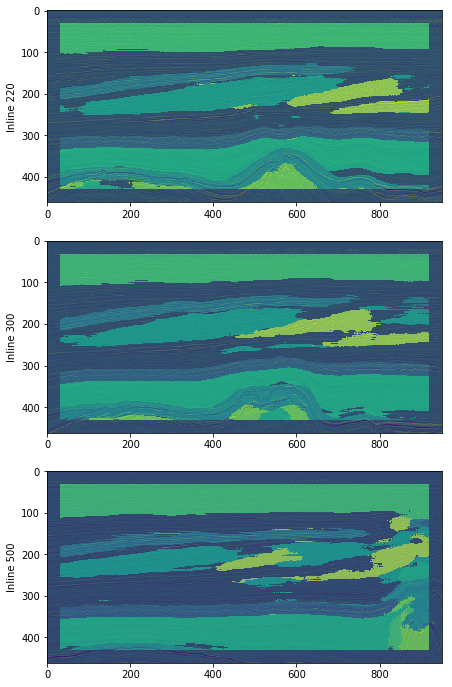

In [108]:
def plot_prediction(ax, seismic, inline, folder):
    indices = np.load(folder+"indices_"+str(inline)+".npy")
    amplitudes = np.load(folder+"amplitudes_"+str(inline)+".npy")

    preds = np.load(folder+"preds_"+str(inline)+".npy")
    img = np.zeros((seismic.shape[1], seismic.shape[2]))

    for index, pred in zip(indices, preds):
        img[index[1], index[2]] = pred
    amplitude_map = seismic[inline, :, :, 0]
    ax.imshow(amplitude_map.T)
    ax.imshow(img.T, alpha=0.5)
    
fig, axarr = plt.subplots(3, 1, figsize=(36, 12))
plot_prediction(axarr[0], seismic, 220, "./results/malenov/180913_2001/outputs/")
plot_prediction(axarr[1], seismic, 300, "./results/malenov/180913_2001/outputs/")
plot_prediction(axarr[2], seismic, 500, "./results/malenov/180913_2001/outputs/")
axarr[0].set_ylabel("Inline 220")
axarr[1].set_ylabel("Inline 300")
axarr[2].set_ylabel("Inline 500")

## Left Right Train/Val Split Results

In [99]:
seismic, X_train, y_train, X_val, y_val = get_train_val_set(use_stratified_kfold=False)

train_dset = MalenovDataset(seismic, X_train, y_train, cube_size)
val_dset = MalenovDataset(seismic, X_val, y_val, cube_size)

train_loader = DataLoader(train_dset, shuffle=True, batch_size=32, num_workers=2)
val_loader = DataLoader(val_dset, shuffle=False, batch_size=32, num_workers=2)

In [100]:
model = MalenovNet()
model.load_state_dict(torch.load("./results/malenov/180913_2034/model_epoch_2.pth.tar")['model'])
model.cuda()
model.eval()

MalenovNet(
  (conv1): Conv3d(1, 50, kernel_size=(5, 5, 5), stride=(4, 4, 4), padding=(2, 2, 2))
  (bn1): BatchNorm3d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(50, 50, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn2): BatchNorm3d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout3d(p=0.2)
  (conv3): Conv3d(50, 50, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn3): BatchNorm3d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout3d(p=0.2)
  (conv4): Conv3d(50, 50, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn4): BatchNorm3d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop4): Dropout3d(p=0.2)
  (conv5): Conv3d(50, 50, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (linear1): Linear(in_features=400, out_features=50, bias=True)
  (bn_ln1): BatchNorm1d(50, eps=1e-05, momentum=0.1, a

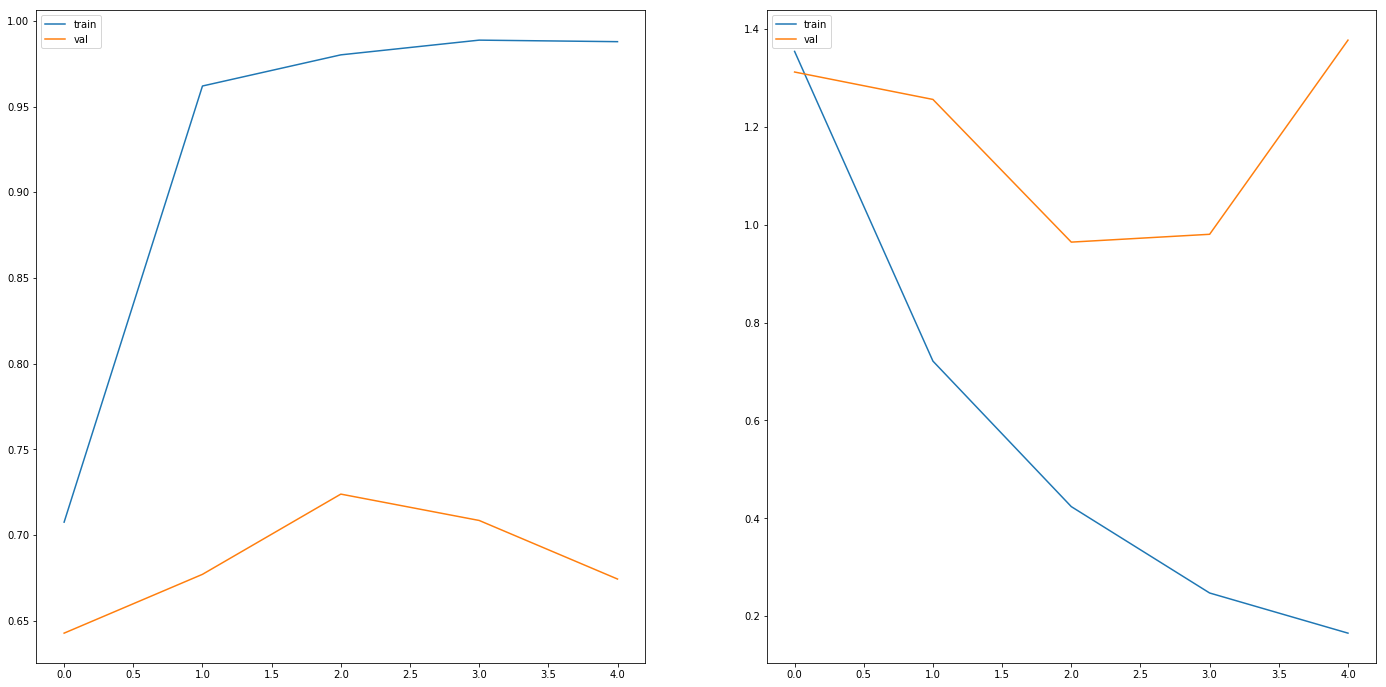

In [101]:
split_train_acc = np.loadtxt("./results/malenov/180913_2034/csv/run_180913_2034_train-tag-accuracy.csv", skiprows=1, delimiter=",")
split_val_acc = np.loadtxt("./results/malenov/180913_2034/csv/run_180913_2034_val-tag-accuracy.csv", skiprows=1, delimiter=",")
split_train_loss = np.loadtxt("./results/malenov/180913_2034/csv/run_180913_2034_train-tag-loss.csv", skiprows=1, delimiter=",")
split_val_loss = np.loadtxt("./results/malenov/180913_2034/csv/run_180913_2034_val-tag-loss.csv", skiprows=1, delimiter=",")

fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].plot(split_train_acc[:, 2], label="train")
ax[0].plot(split_val_acc[:, 2], label="val")

ax[1].plot(split_train_loss[:, 2], label="train")
ax[1].plot(split_val_loss[:, 2], label="val")
ax[0].legend()
ax[1].legend()

In [102]:
model.eval()
train_preds = []
train_labels = []
with torch.set_grad_enabled(False):
    for i, (X, y) in enumerate(tqdm(train_loader)):
        y_pred = model(X.to(device))
        pred = torch.argmax(F.softmax(y_pred.detach(), 1), 1)
        train_preds.extend(pred.cpu().numpy())
        train_labels.extend(y.cpu().numpy())

In [103]:
train_accuracy = accuracy_score(y_true=train_labels, y_pred=train_preds)
print(train_accuracy)

train_cnf = confusion_matrix(y_true=train_labels, y_pred=train_preds)
print(train_cnf)

0.998892548433028
[[11625     0    29     0     3     0    33     0     0]
 [    0  9905     0     0     0     0     0     0     0]
 [    1     0  5788     0     0     0     0     0     0]
 [    0     0     0  5580     0     0     0     0     0]
 [    0     0     0     0 13360     0     0     0     0]
 [    0     3     0     0     0  8846     0     0     0]
 [    0     0     0     0     0     0  8362     0     0]
 [    0     0     0     0     0     0     0   646     0]
 [    4     4     0     0     0     0     0     0  5340]]


In [104]:
model.eval()
val_preds = []
val_labels = []
with torch.set_grad_enabled(False):
    for i, (X, y) in enumerate(tqdm(val_loader)):
        y_pred = model(X.to(device))
        pred = torch.argmax(F.softmax(y_pred.detach(), 1), 1)
        val_preds.extend(pred.cpu().numpy())
        val_labels.extend(y.cpu().numpy())

In [105]:
val_accuracy = accuracy_score(y_true=val_labels, y_pred=val_preds)
print(val_accuracy)

val_cnf = confusion_matrix(y_true=val_labels, y_pred=val_preds)
print(val_cnf)

0.7239232907618549
[[4390  232   59  653  600  198  789    0  145]
 [   0 6371    0    0    0    0    0    0    0]
 [2201    0 3836    0    0    0    0    0    0]
 [   0  291    0 3774    0    0    0    4    0]
 [ 159    0    0    0 2330    0    0    0    0]
 [   0    8    0   11    0 8142   72    0    0]
 [   0    0    0    0    0   21 6948    0    0]
 [   0   24    0    0    0  728    0    0    0]
 [3156   40 2238    0 1974    0  102    0  146]]


## Results Visualization on a few Inlines

Text(0,0.5,'Inline 500')

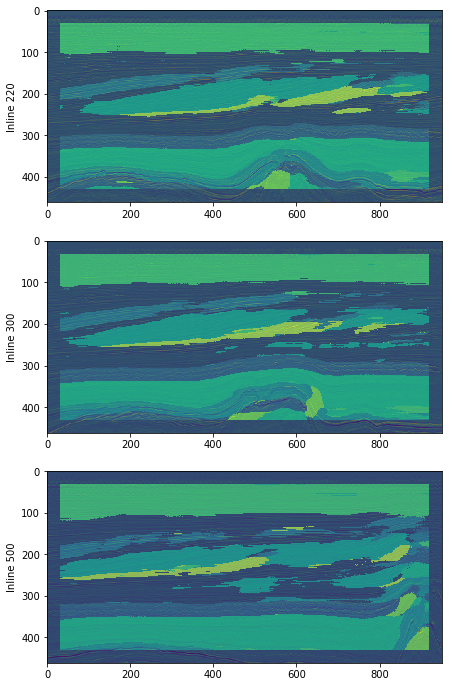

In [111]:
def plot_prediction(ax, seismic, inline, folder):
    indices = np.load(folder+"indices_"+str(inline)+".npy")
    amplitudes = np.load(folder+"amplitudes_"+str(inline)+".npy")

    preds = np.load(folder+"preds_"+str(inline)+".npy")
    img = np.zeros((seismic.shape[1], seismic.shape[2]))

    for index, pred in zip(indices, preds):
        img[index[1], index[2]] = pred
    amplitude_map = seismic[inline, :, :, 0]
    ax.imshow(amplitude_map.T)
    ax.imshow(img.T, alpha=0.5)
    
fig, axarr = plt.subplots(3, 1, figsize=(36, 12))
plot_prediction(axarr[0], seismic, 220, "./results/malenov/180913_2034/outputs/")
plot_prediction(axarr[1], seismic, 300, "./results/malenov/180913_2034/outputs/")
plot_prediction(axarr[2], seismic, 500, "./results/malenov/180913_2034/outputs/")
axarr[0].set_ylabel("Inline 220")
axarr[1].set_ylabel("Inline 300")
axarr[2].set_ylabel("Inline 500")